Database Download

In [1]:
!wget http://ai.stanford.edu/%7Eamaas/data/sentiment/aclImdb_v1.tar.gz

--2023-04-24 17:18:50--  http://ai.stanford.edu/%7Eamaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  39.9MB/s    in 2.0s    

2023-04-24 17:18:52 (39.9 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
!tar -xf aclImdb_v1.tar.gz

Imports

In [14]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

Auxiliary Functions

In [18]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names_out())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

Load Data

In [8]:
imdb_data_path = 'aclImdb'
seed = 123

# Load the training data
train_texts = []
train_labels = []
for category in ['pos', 'neg']:
    train_path = os.path.join(imdb_data_path, 'train', category)
    for fname in sorted(os.listdir(train_path)):
        if fname.endswith('.txt'):
            with open(os.path.join(train_path, fname)) as f:
                train_texts.append(f.read())
            train_labels.append(0 if category == 'neg' else 1)

# Load the validation data.
test_texts = []
test_labels = []
for category in ['pos', 'neg']:
    test_path = os.path.join(imdb_data_path, 'test', category)
    for fname in sorted(os.listdir(test_path)):
        if fname.endswith('.txt'):
            with open(os.path.join(test_path, fname)) as f:
                test_texts.append(f.read())
            test_labels.append(0 if category == 'neg' else 1)

# Shuffle the training data and labels.
random.seed(seed)
random.shuffle(train_texts)
random.seed(seed)
random.shuffle(train_labels)

Metrics

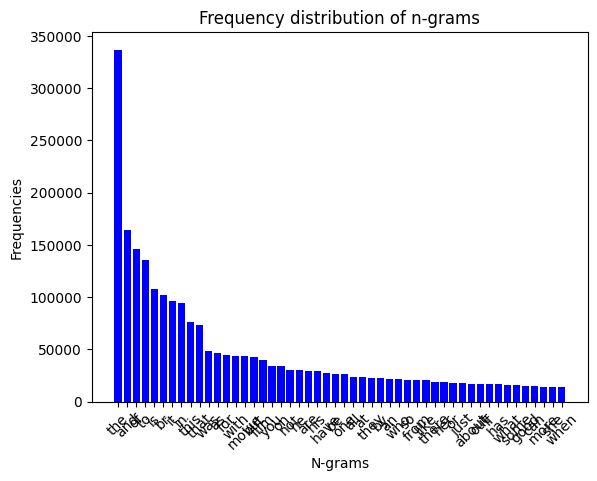

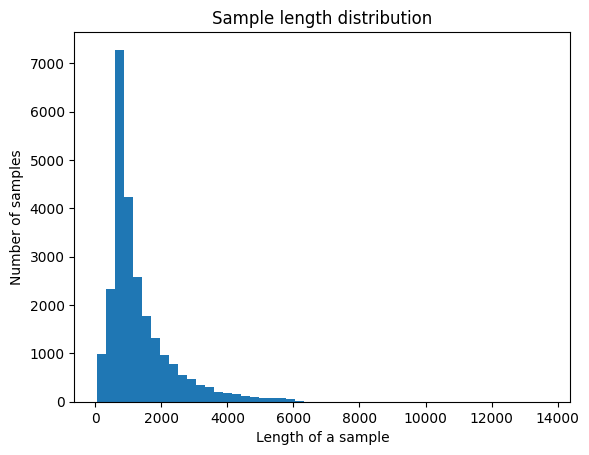

In [20]:
plot_frequency_distribution_of_ngrams(train_texts)
print()
plot_sample_length_distribution(train_texts)

Vectorization

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

Preprocessing 

In [39]:
from keras.preprocessing import sequence
from keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

Model - Auxiliary Functions

In [49]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

Model

In [70]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

Train

In [74]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                      units=units,
                      dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:],
                      num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer= 'adam', loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]